# Summary

This notebook comprises all experiments we performed in order to compare various internal scores for clustering.

In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
import random
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import pickle
import scripts.data_generator as data_generator
import scripts.validation_open_ensembles as validation
plt.ion()
plt.show()

random_state=0
random.seed( random_state )
np.random.seed(random_state)

plt.ion()
plt.show()
path = "../"

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Utility functions

In [2]:
def plot(data_x, truth):
    import scripts.plot_utils as plot_utils
    from sklearn.decomposition import PCA
    
    predK = KMeans(n_clusters= n_clusters, random_state =0).fit(data_x).labels_
    ari = adjusted_rand_score(truth, predK)
    method = "adapted_ratkowsky_lance"
    v = validation.validation(data_x, predK)
    score=  getattr(v, method)()
    print(f'ARI  {round(ari,2)}, {method} {score}')
    
    pca = PCA(2, random_state = 0)
    pca_data = pca.fit_transform(data_x)
    plotPCA = True
    plotSilhouette = True
    if plotPCA or plotSilhouette:
        plt.figure(figsize=(4*(plotPCA*2+plotSilhouette),3))
    if plotPCA:
        plt.subplot(1,plotPCA*2+plotSilhouette,1)
        plt.title("PCA truth")
        plt.scatter(pca_data[:, 0],pca_data[:, 1], c = truth)
        plt.subplot(1,plotPCA*2+plotSilhouette,2)
        plt.title("PCA pred")
        plt.scatter(pca_data[:, 0],pca_data[:, 1], c = predK)
    if plotSilhouette:
        ax = plt.subplot(1,2*plotPCA+plotSilhouette,2*plotPCA+plotSilhouette)
        plot_utils.silhouette_plot(pca_data, truth, ax=ax)
    plt.show()

    
def get_scores(data, ids, ground_truth):
    values = []
    for ii in ids:
        v = validation.validation(data[:, ii], ground_truth)
        score=  getattr(v, method)()
        values.append(score)
    return values

def add_candidates(data, candidates, prev_pure_ids, prev_pure_scores):
    new_ids = []
    reference_scores = []
    for i in range(len(prev_pure_ids)):
        current_candidates = np.setdiff1d(candidates, prev_pure_ids[i])
        if len(current_candidates) == 0:
            break
        new_ids.extend([np.append(prev_pure_ids[i],c) for c in current_candidates])
        reference_scores.extend([prev_pure_scores[i]] * len(current_candidates))

    new_scores = get_scores(data, new_ids, ground_truth)

    deltas = np.array(new_scores) - np.array(reference_scores)
    return new_ids, new_scores, deltas

def evaluate_method(method, data, ground_truth, n_definingfeatures, plot_subpaces = False):
    junk_features = np.setdiff1d(np.arange(data.shape[1]), np.arange(n_definingfeatures))
    pure_features = np.arange(n_definingfeatures)
    
    prev_pure_ids = list(itertools.combinations(pure_features, 2))
    prev_pure_scores = get_scores(data, prev_pure_ids, ground_truth)
    delta_pure = []
    delta_impure = []
    max_score_pure = [max(prev_pure_scores)]

    for ss in range(3,7, 1):
        # Handle junk features
        candidates = junk_features
        new_ids_junk, new_scores_junk, deltas_junk = add_candidates(data, candidates, prev_pure_ids, prev_pure_scores)

        candidates = pure_features
        new_ids_pure, new_scores_pure, deltas_pure = add_candidates(data, candidates, prev_pure_ids, prev_pure_scores)

        if plot_subpaces:
            plt.figure(figsize=(12, 4))
            ax = plt.subplot(121)
            plt.title(f"good features {ss}")
            plt.boxplot([deltas_pure, deltas_junk])
            ax.set_xticklabels(['Pure', 'Pure + 1junk',])
            plt.show()



        if len(new_scores_pure)>0:
            max_score_pure.append(np.max(new_scores_pure))
            prev_pure_ids = new_ids_pure
            prev_pure_scores = new_scores_pure
            delta_pure.append(deltas_pure)
            delta_impure.append(deltas_junk)
        else:
            prev_pure_ids = new_ids_junk
            prev_pure_scores = new_scores_junk

#     plt.figure(figsize=(12, 4))
#     ax = plt.subplot(121)
#     plt.title(f"Overall {method}")
#     plt.boxplot([np.concatenate(delta_pure), np.concatenate(delta_impure)])
#     ax.set_xticklabels(['Pure', 'Pure + 1junk',])
#     plt.grid()
#     plt.show()
    
    max_score_pure = preprocessing.MinMaxScaler().fit_transform(
        np.array(max_score_pure).reshape(-1, 1)).reshape(-1)
    
    return delta_pure, delta_impure, max_score_pure


methods = [
    "silhouette",
    "calinski_harabasz",
    "Dunns_index",
    "Davies_Bouldin",
    "Ratkowsky_Lance",
    "adapted_ratkowsky_lance",
    "adapted_silhouette",
]

pretty_names = {
    "silhouette": "Silhouette",
    "calinski_harabasz": "Calinski Harabasz",
    "Dunns_index": "Dunn index",
    "Davies_Bouldin": "Davies Bouldin",
    "Ratkowsky_Lance": "Ratkowsky Lance",
    "adapted_ratkowsky_lance": "Penalized Ratkowsky Lance",
    "adapted_silhouette": "Penalized Silhouette",
}

# Generate the data

In [ ]:
nb_subspaces = 1
n_clusters = 5
n_samples = np.random.randint(30, 50) * n_clusters
cluster_std = 0.14

random_state = 5
n_definingfeatures = 8
n_uniform_features=5
n_normal_features=5

data, truths = data_generator.make_data_for_loss(n_subspaces=nb_subspaces, n_clusters = n_clusters
                        , n_samples = None, cluster_std = cluster_std
                        , random_state = random_state, n_definingfeatures = n_definingfeatures
                        , n_uniform_features = n_uniform_features, n_normal_features=n_normal_features)
print(data.shape)
ground_truth = truths[0]

dataset_name = "generated blobs"

In [ ]:
all_datasets = {"generated blobs": {"data": data, "ground_truth": truths[0]}}

# Microarray analysis

### Choose datasets with the biggest difference between top and worse features by ari

In [ ]:
path = '../data/microarray/'
filenames = np.array([ 'khan', 'west', 'gordon','borovecki']) 

results = pd.DataFrame(columns=[
    "dataset", "n_clusters", "n", "d", "ari all features",
    "ari top 5 features", "ari bottom 5 features", "delta aris"
])
for name in filenames:
    data = pd.read_pickle(f'{path}' + name + '.pkl')
    truth = data["truth"].values
    data = data.drop("truth", axis=1).values
    n_clusters = len(np.unique(truth))
    n_definingfeatures = 5
    data_imp = data[:, :n_definingfeatures]
    data_noise = data[:, -n_definingfeatures:]

    predK = KMeans(n_clusters=n_clusters, random_state=0).fit(data).labels_
    ari_all = adjusted_rand_score(truth, predK)

    predK = KMeans(n_clusters=n_clusters, random_state=0).fit(data_imp).labels_
    ari_imp = adjusted_rand_score(truth, predK)
    predK = KMeans(n_clusters=n_clusters,
                   random_state=0).fit(data_noise).labels_
    ari_noise = adjusted_rand_score(truth, predK)
    results.loc[results.shape[0]] = [
        name, n_clusters, data.shape[0], data.shape[1], ari_all, ari_imp,
        ari_noise, ari_imp - ari_noise
    ]

results.sort_values(by = "delta aris", ascending = False)

In [ ]:
# dataset_name = "west"
# path = '../data/microarray/'
# data = pd.read_pickle(f'{path}' + dataset_name + '.pkl')
# ground_truth = data["truth"].values
# data = data.drop("truth", axis = 1).values

# n_clusters = len(np.unique(ground_truth))

# n_definingfeatures = 5
# data_imp = data[:, :n_definingfeatures]
# data_noise = data[:, -n_definingfeatures*2:]
# data = np.hstack([data_imp, data_noise])
# data = preprocessing.MinMaxScaler().fit_transform(data)

In [ ]:
selected = ["khan", "gordon", "west"]

for dataset_name in selected:
    path = '../data/microarray/'
    data = pd.read_pickle(f'{path}' + dataset_name + '.pkl')
    ground_truth = data["truth"].values
    data = data.drop("truth", axis = 1).values

    n_clusters = len(np.unique(ground_truth))

    n_definingfeatures = 5
    data_imp = data[:, :n_definingfeatures]
    data_noise = data[:, -n_definingfeatures*2:]
    data = np.hstack([data_imp, data_noise])
    data = preprocessing.MinMaxScaler().fit_transform(data)
    all_datasets[dataset_name]= {"data": data, "ground_truth": ground_truth}



with open('../data/loss_comparaison.pkl', 'wb') as f:
    pickle.dump(all_datasets, f)

# Start from here if data has been already generated

In [3]:
with open('../data/loss_comparaison.pkl', 'rb') as f:
    all_datasets = pickle.load(f)

In [4]:
n_definingfeatures = 5

for dataset_name, dataset_values in all_datasets.items():
    data = dataset_values["data"]
    ground_truth = dataset_values["ground_truth"]
    results = {}
    for method in methods:
        delta_pure, delta_impure, max_score_pure = evaluate_method(method,
                                               data,
                                               ground_truth,
                                               n_definingfeatures,
                                               plot_subpaces=False)
        results[method] = {"pure" : delta_pure, "impure": delta_impure, "max_score_pure" : max_score_pure}
    all_datasets[dataset_name]["results"] = results

# Boxplot figure with original internal scores

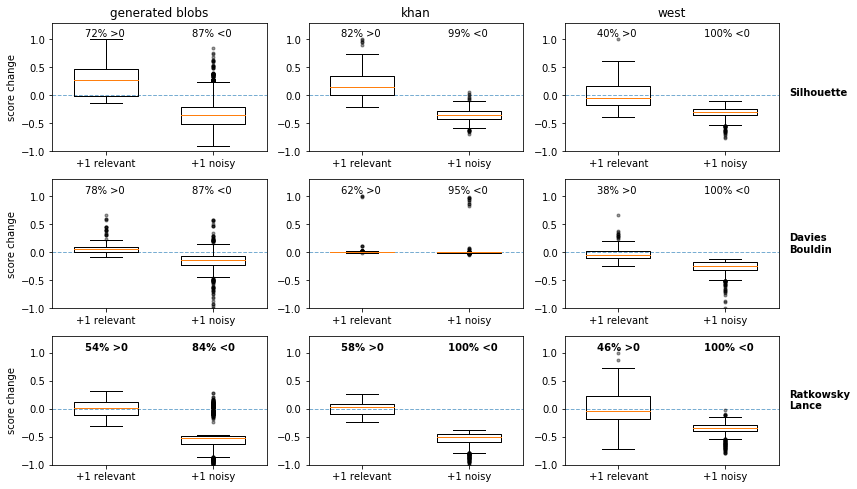

In [5]:
pretty_names = {
    "silhouette": "Silhouette",
    "calinski_harabasz": "Calinski\nHarabasz",
    "Dunns_index": "Dunnn\index",
    "Davies_Bouldin": "Davies\nBouldin",
    "Ratkowsky_Lance": "Ratkowsky\nLance",
    "adapted_ratkowsky_lance": "Adapted\nRatkowsky\nLance"
}

selected_methods = ['silhouette',
 'Davies_Bouldin',
 'Ratkowsky_Lance'
                   ]
selected_datasets =['generated blobs', 'khan', 'west']
n_rows = len(selected_methods)
fig = plt.figure(figsize=(12, 2.3* n_rows)) #, constrained_layout=False

for i, method_name in enumerate(selected_methods):
    for j,(dataset_name) in enumerate(selected_datasets):
        results = all_datasets[dataset_name]["results"]
        delta_pure = np.concatenate(results[method_name]["pure"])
        delta_impure = np.concatenate(results[method_name]["impure"])
        
        max_val = np.max(np.concatenate([np.abs(delta_pure), np.abs(delta_impure)]))
        
        delta_pure = delta_pure/max_val
        delta_impure = delta_impure/max_val

        if method_name == 'Davies_Bouldin':
            delta_pure = -delta_pure
            delta_impure = -delta_impure
            
        p1 = int((100* len(np.where(delta_pure>=0)[0])/len(delta_pure)))
        p2 = int((100* len(np.where(delta_impure<0)[0])/len(delta_impure)))
        ax = plt.subplot(n_rows, len(selected_datasets),i*len(selected_datasets) + j+1)
        if i == 0:
#             plt.title(f"{pretty_names[method_name]}")
            plt.title(f"{dataset_name}")
        flierprops = dict(marker='o', markerfacecolor='black', markersize=3,
                      linestyle='none', alpha =.4)


        plt.boxplot([delta_pure, delta_impure],
                   flierprops = flierprops, widths=.6, zorder=10)
        ax.set_xticklabels(['+1 relevant', '+1 noisy',])
        m = np.max(np.abs(list(ax.get_ylim())))
        plt.ylim(-1, 1.3)
        fontweight = 'normal' if i!= len(selected_methods)-1 else 'bold'
        plt.text(0.8, 1.05, f"{p1}% >0", fontweight = fontweight)
        plt.text(1.8, 1.05, f"{p2}% <0", fontweight = fontweight)
        if j == 0:
            plt.ylabel(f"score change")
        plt.axhline(y=0, linestyle = "--", alpha = 0.6, linewidth=1)
        if j == len(selected_datasets) - 1:
            plt.text(2.6, 0, f"{pretty_names[method_name]}", weight='bold')

plt.tight_layout()

plt.savefig(f"../images/loss_purity_comparaison_reduced.pdf", bbox_inches='tight')

# Boxplot figure with penalized internal scores

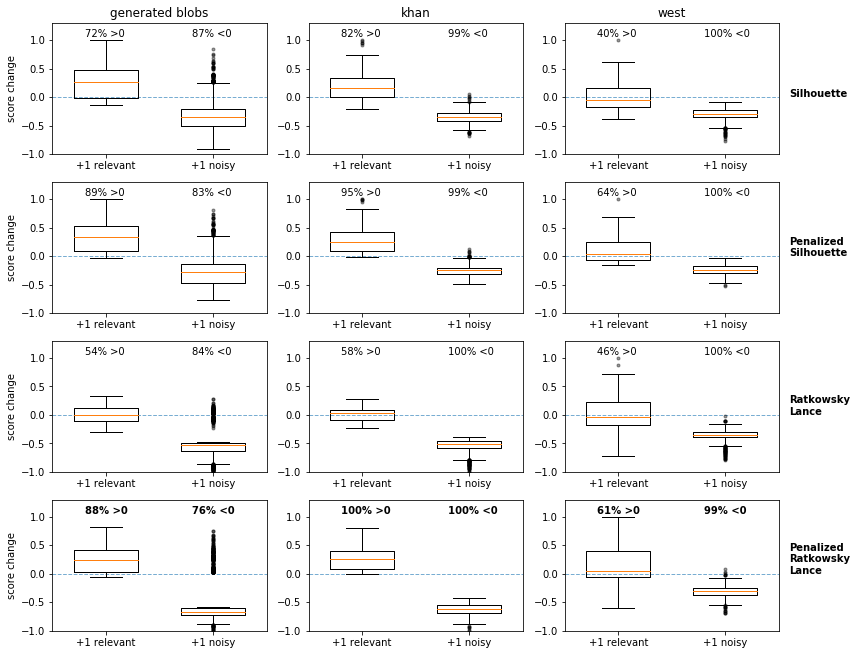

In [6]:
pretty_names['adapted_ratkowsky_lance']= 'Penalized\nRatkowsky\nLance'
pretty_names['Ratkowsky_Lance']= 'Ratkowsky\nLance'
pretty_names['adapted_silhouette']= 'Penalized\nSilhouette'

selected_methods = ['silhouette', 'adapted_silhouette', 'Ratkowsky_Lance', 'adapted_ratkowsky_lance', ]
selected_datasets =['generated blobs', 'khan'
                    'west']
n_rows = len(selected_methods)
fig = plt.figure(figsize=(12, 2.3* n_rows)) #, constrained_layout=False

for i, method_name in enumerate(selected_methods):
    
    for j,(dataset_name) in enumerate(selected_datasets):
        results = all_datasets[dataset_name]["results"]
        delta_pure = np.concatenate(results[method_name]["pure"])
        delta_impure = np.concatenate(results[method_name]["impure"])
        
        max_val = np.max(np.concatenate([np.abs(delta_pure), np.abs(delta_impure)]))
        
        delta_pure = delta_pure/max_val
        delta_impure = delta_impure/max_val

        if method_name == 'Davies_Bouldin':
            delta_pure = -delta_pure
            delta_impure = -delta_impure
            
        p1 = int((100* len(np.where(delta_pure>=0)[0])/len(delta_pure)))
        p2 = int((100* len(np.where(delta_impure<0)[0])/len(delta_impure)))
        ax = plt.subplot(n_rows, len(selected_datasets),i*len(selected_datasets) + j+1)
        if i == 0:
#             plt.title(f"{pretty_names[method_name]}")
            plt.title(f"{dataset_name}")
        flierprops = dict(marker='o', markerfacecolor='black', markersize=3,
                      linestyle='none', alpha =.4)


        plt.boxplot([delta_pure, delta_impure],
                   flierprops = flierprops, widths=.6, zorder=10)
        ax.set_xticklabels(['+1 relevant', '+1 noisy',])
        m = np.max(np.abs(list(ax.get_ylim())))
        plt.ylim(-1, 1.3)
        fontweight = 'normal' if i!= len(selected_methods)-1 else 'bold'
        plt.text(0.8, 1.05, f"{p1}% >0", fontweight = fontweight)
        plt.text(1.8, 1.05, f"{p2}% <0", fontweight = fontweight)
        if j == 0:
            plt.ylabel(f"score change")
        plt.axhline(y=0, linestyle = "--", alpha = 0.6, linewidth=1)
        if j == len(selected_datasets) - 1:
            plt.text(2.6, 0, f"{pretty_names[method_name]}", weight='bold')

plt.tight_layout()

# plt.suptitle("Score change by adding one relevant vs noisy feature to an existing subspace "+
#              f"of 2,3,4 and 5 good features on {dataset_name}")
# fig.subplots_adjust(wspace=0.3, top = 0.93)
plt.savefig(f"../images/loss_purity_comparaison_ratkowski.pdf", bbox_inches='tight')

# Evaluate ranges of values for internal scores on subspaces having 2-40 features

In [ ]:
from tqdm import tqdm
import scipy

nb_subspaces = 1
n_clusters = 5
n_samples = np.random.randint(30, 50) * n_clusters
cluster_std = 0.14

random_state = 5
n_definingfeatures = 40
n_uniform_features=40
n_normal_features=40

data, truths = data_generator.make_data_for_loss(n_subspaces=nb_subspaces, n_clusters = n_clusters
                        , n_samples = None, cluster_std = cluster_std
                        , random_state = random_state, n_definingfeatures = n_definingfeatures
                        , n_uniform_features = n_uniform_features, n_normal_features=n_normal_features)
print(data.shape)
ground_truth = truths[0]

dataset_name = "generated blobs"

In [ ]:
method = "Ratkowsky_Lance" #"calinski_harabasz"## "adapted_ratkowsky_lance"

max_combinations = 1500
all_scores = []
for i in range(2, n_definingfeatures):
#     n = len(list(itertools.combinations(np.arange(n_definingfeatures), i)))
    n = scipy.special.comb(n_definingfeatures,i)
    if max_combinations is not None and n > max_combinations:
#         print(f"{i} sampling {n}")
        # do sampling                                   
        scores = np.zeros(max_combinations)
        for j in range(max_combinations):
            idx = np.random.choice(np.arange(n_definingfeatures), replace = False, size = i)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    else:
#         print(f"{i} exhaustive {n}")
        scores = np.zeros(int(n))
        for j,idx in enumerate(itertools.combinations(np.arange(n_definingfeatures), i)):
            idx = np.array(idx)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    all_scores.append(scores)

In [ ]:
norm_factor = np.arange(2, len(all_scores) + 2)/(np.arange(2, len(all_scores) + 2)+1)

# Combined plot

In [ ]:
plt.figure(figsize = (11, 10))

method = "silhouette" #"calinski_harabasz"## "adapted_ratkowsky_lance"
method_name = "Silhouette"
letters = ["a", "b"]
max_combinations = 1500
all_scores = []
for i in range(2, n_definingfeatures):
#     n = len(list(itertools.combinations(np.arange(n_definingfeatures), i)))
    n = scipy.special.comb(n_definingfeatures,i)
    if max_combinations is not None and n > max_combinations:
#         print(f"{i} sampling {n}")
        # do sampling                                   
        scores = np.zeros(max_combinations)
        for j in range(max_combinations):
            idx = np.random.choice(np.arange(n_definingfeatures), replace = False, size = i)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    else:
#         print(f"{i} exhaustive {n}")
        scores = np.zeros(int(n))
        for j,idx in enumerate(itertools.combinations(np.arange(n_definingfeatures), i)):
            idx = np.array(idx)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    all_scores.append(scores)
norm_factor = np.arange(2, len(all_scores) + 2)/(np.arange(2, len(all_scores) + 2)+1)

x = np.arange(2, len(all_scores) + 2)
y1 = [min(all_scores[i]) for i in range(len(all_scores))]
y2 = [max(all_scores[i]) for i in range(len(all_scores))]
medians = [np.median(all_scores[i]) for i in range(len(all_scores))]
ax = plt.subplot(411)
plt.title(f"({letters[0]}) Range of {method_name} score per subspace size for a {n_definingfeatures} D blob")
plt.plot(x,y1, label =f"Minimum {method_name} score", color = "royalblue")
plt.plot(x, y2, label =f"Maximum {method_name} score", color = "orange")
plt.plot(x, medians, label =f"Median {method_name} score", linestyle = "--", color = "black")
plt.fill_between(x, y1, y2 , color = "gray", alpha = 0.2)
plt.xlabel("Subspace size")
plt.ylabel(f"{method_name} score")

ax.spines["top"].set_visible(False)
ax = ax.twinx()
plt.plot(x,norm_factor, label = "Normalization function", color = "firebrick")
plt.ylabel("Normalization score")

plt.legend(
    handles = [
        Line2D([0],[0], color='orange', lw=2,  label = "Maximum Score"),
        Line2D([0],[0], color='royalblue', lw=2,  label = "Minimum Score"),
        Line2D([0],[0], color='black', lw=2, linestyle='--', label = "Median Score"),
        Line2D([0],[0], color='firebrick', lw=2,label = "Normalization function"),
        Patch(facecolor= "gray", alpha = 0.2, label='Range of scores')
    ]
    ,
    loc = "lower right")
# plt.plot(np.arange(2, len(all_scores) + 2),1/norm_factor)
ax.spines["top"].set_visible(False)
ax = plt.subplot(412)

y1_2 = [min(all_scores[i]) * norm_factor[i] for i in range(len(all_scores))]
y2_2 = [max(all_scores[i]) * norm_factor[i] for i in range(len(all_scores))]
medians = [np.median(all_scores[i])  * norm_factor[i] for i in range(len(all_scores))]

plt.title(f"({letters[1]}) Penalized {method_name} scores per subspace size ")
plt.plot(x,y1_2, label =f"Minimum {method_name} score", color = "royalblue")
plt.plot(x, y2_2, label =f"Maximum {method_name} score", color = "orange")
plt.plot(x, medians, label =f"Median {method_name} score", linestyle = "--", color = "black")
plt.fill_between(x, y1_2, y2_2 , color = "gray", alpha = 0.2)
plt.xlabel("Subspace size")
plt.ylabel(f"{method_name} score")
ax.spines["top"].set_visible(False)
plt.legend(
    handles = [
        Line2D([0],[0], color='orange', lw=2,  label = "Maximum Score"),
        Line2D([0],[0], color='royalblue', lw=2,  label = "Minimum Score"),
        Line2D([0],[0], color='black', lw=2, linestyle='--', label = "Median Score"),

        Patch(facecolor= "gray", alpha = 0.2, label='Range of scores')
    ]
    ,
    loc = "lower right")



method = "Ratkowsky_Lance" #"calinski_harabasz"## "adapted_ratkowsky_lance"
method_name = "Ratkowsky Lance"
letters = ["c", "d"]
max_combinations = 1500
all_scores = []
for i in range(2, n_definingfeatures):
#     n = len(list(itertools.combinations(np.arange(n_definingfeatures), i)))
    n = scipy.special.comb(n_definingfeatures,i)
    if max_combinations is not None and n > max_combinations:
#         print(f"{i} sampling {n}")
        # do sampling                                   
        scores = np.zeros(max_combinations)
        for j in range(max_combinations):
            idx = np.random.choice(np.arange(n_definingfeatures), replace = False, size = i)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    else:
#         print(f"{i} exhaustive {n}")
        scores = np.zeros(int(n))
        for j,idx in enumerate(itertools.combinations(np.arange(n_definingfeatures), i)):
            idx = np.array(idx)
            v = validation.validation(data[:, idx], truths[0])
            scores[j]=  getattr(v, method)()
    all_scores.append(scores)
norm_factor = np.arange(2, len(all_scores) + 2)/(np.arange(2, len(all_scores) + 2)+1)

x = np.arange(2, len(all_scores) + 2)
y1 = [min(all_scores[i]) for i in range(len(all_scores))]
y2 = [max(all_scores[i]) for i in range(len(all_scores))]
medians = [np.median(all_scores[i]) for i in range(len(all_scores))]
ax = plt.subplot(413)
plt.title(f"({letters[0]}) Range of {method_name} score per subspace size for a {n_definingfeatures} D blob")
plt.plot(x,y1, label =f"Minimum {method_name} score", color = "royalblue")
plt.plot(x, y2, label =f"Maximum {method_name} score", color = "orange")
plt.plot(x, medians, label =f"Median {method_name} score", linestyle = "--", color = "black")
plt.fill_between(x, y1, y2 , color = "gray", alpha = 0.2)
plt.xlabel("Subspace size")
plt.ylabel(f"{method_name} score")

ax.spines["top"].set_visible(False)
ax = ax.twinx()
plt.plot(x,norm_factor, label = "Normalization function", color = "firebrick")
plt.ylabel("Normalization score")

plt.legend(
    handles = [
        Line2D([0],[0], color='orange', lw=2,  label = "Maximum Score"),
        Line2D([0],[0], color='royalblue', lw=2,  label = "Minimum Score"),
        Line2D([0],[0], color='black', lw=2, linestyle='--', label = "Median Score"),
        Line2D([0],[0], color='firebrick', lw=2,label = "Normalization function"),
        Patch(facecolor= "gray", alpha = 0.2, label='Range of scores')
    ]
    ,
    loc = "lower right")
# plt.plot(np.arange(2, len(all_scores) + 2),1/norm_factor)
ax.spines["top"].set_visible(False)
ax = plt.subplot(414)

y1_2 = [min(all_scores[i]) * norm_factor[i] for i in range(len(all_scores))]
y2_2 = [max(all_scores[i]) * norm_factor[i] for i in range(len(all_scores))]
medians = [np.median(all_scores[i])  * norm_factor[i] for i in range(len(all_scores))]

plt.title(f"({letters[1]}) Penalized {method_name} scores per subspace size ")
plt.plot(x,y1_2, label =f"Minimum {method_name} score", color = "royalblue")
plt.plot(x, y2_2, label =f"Maximum {method_name} score", color = "orange")
plt.plot(x, medians, label =f"Median {method_name} score", linestyle = "--", color = "black")
plt.fill_between(x, y1_2, y2_2 , color = "gray", alpha = 0.2)
plt.xlabel("Subspace size")
plt.ylabel(f"{method_name} score")
ax.spines["top"].set_visible(False)
plt.legend(
    handles = [
        Line2D([0],[0], color='orange', lw=2,  label = "Maximum Score"),
        Line2D([0],[0], color='royalblue', lw=2,  label = "Minimum Score"),
        Line2D([0],[0], color='black', lw=2, linestyle='--', label = "Median Score"),

        Patch(facecolor= "gray", alpha = 0.2, label='Range of scores')
    ]
    ,
    loc = "lower right")


plt.tight_layout()
plt.savefig(f"../images/loss_normalization_methods.pdf",  bbox_inches='tight')